In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from FNORUNet_4layer_model import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io
import math
import gc
import glob

torch.manual_seed(0)
np.random.seed(0)

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from scipy import stats

In [2]:
hf_r = h5py.File(f'/oak/stanford/schools/ees/smbenson/andchu/shale_clean.hdf5', 'r')
data_x_shale = np.array(hf_r.get('x'))
data_SG_shale = np.array(hf_r.get('SG'))
data_P_shale = np.array(hf_r.get('P'))
data_P_init_shale = np.array(hf_r.get('P_init'))
hf_r.close()
del hf_r # clear up memory
print('Checkpoint 1')

Checkpoint 1


In [3]:
data_SG_shale.shape

(3616, 24, 96, 200)

In [4]:
# GAS SATURATION DATA -------------------------------------------------
# Z SCORE NORMALIZATION
SG_mean = np.mean(data_SG_shale)
SG_std = np.std(data_SG_shale)
print(SG_mean)
print(SG_std)
    
data_SG_shale = (data_SG_shale - SG_mean)/(SG_std)

0.019367479650039064
0.10341674964334545


In [5]:
data_x = np.concatenate([data_x_shale], axis=0)

In [6]:
data_sg = np.concatenate([data_SG_shale], axis=0)

In [7]:
# only need data from indices 3, 35, 102
data_nr = data_x.shape[0]
test_nr = 600
train_nr = data_nr - test_nr

np.random.seed(0)
shuffle_index = np.random.choice(data_nr, data_nr, replace=False)

In [8]:
# Indices we want
print(np.where(shuffle_index == train_nr+4))
print(np.where(shuffle_index == train_nr+36))
print(np.where(shuffle_index == train_nr+103))

(array([2529]),)
(array([3416]),)
(array([414]),)


In [9]:
list_of_indices = [2529, 3416, 414]
data_x2 = data_x[list_of_indices, :, :, :]
print(data_x2.shape)

data_sg2 = data_sg[list_of_indices, :, :, :]
print(data_sg2.shape)

print('Checkpoint 2')

(3, 24, 96, 200)
(3, 24, 96, 200)
Checkpoint 2


In [10]:
idx = [0,6,12,18,19,20,21,22,23]
data_x2_fit = np.zeros((data_x2.shape[0], len(idx)+3, 96, 200))
for j, index in enumerate(idx):
    data_x2_fit[:,j,:,:] = data_x2[:,index,:,:]
    
print('Checkpoint 3')

Checkpoint 3


In [11]:
dz = 2.083330
dx = [0.1]

with open('DRV.txt') as f:
    for line in f:
        line = line.strip().split('*')
        dx.append(float(line[-1]))
dx = np.cumsum(dx)
grid_x = dx/np.max(dx)
grid_x = grid_x[1:]
grid_y = np.linspace(0, 200, 96)/np.max(dx)

In [12]:
data_x2_fit[:,-3,:,:] = grid_x[np.newaxis, np.newaxis, :]
data_x2_fit[:,-2,:,:] = grid_y[np.newaxis, :, np.newaxis]
data_x2_fit[:,-1,:,:] = np.ones(data_x2_fit[:,-1,:,:].shape)

data_x2_fit[:,-3,:,:] = data_x2_fit[:,-3,:,:]/np.max(data_x2_fit[:,-3,:,:])
data_x2_fit[:,-2,:,:] = data_x2_fit[:,-2,:,:]/np.max(data_x2_fit[:,-2,:,:])

In [13]:
x_in = data_x2_fit.transpose((0,2,3,1))
SG = data_sg2.transpose((0,2,3,1))

x_in = x_in.astype(np.float32)
SG = SG.astype(np.float32)

x_in = torch.from_numpy(x_in)
SG = torch.from_numpy(SG)

print('Checkpoint 4')

Checkpoint 4


In [14]:
# a input u output
# train_a = x_in[:train_nr,:,:,:]
# train_u = SG[:train_nr,:,:,:]

# test_a = x_in[train_nr:train_nr+ test_nr,:,:,:]
# test_u = SG[train_nr:train_nr+ test_nr,:,:,:]
test_a = x_in
test_u = SG

T = 24

# train_a = train_a[:,:,:,np.newaxis,:]
test_a = test_a[:,:,:,np.newaxis,:]

# train_a = train_a.repeat([1,1,1,T,1])
test_a = test_a.repeat([1,1,1,T,1])

print('Checkpoint 5')

Checkpoint 5


In [15]:
t = np.cumsum(np.power(1.421245, range(24)))
t /= np.max(t)
for i in range(24):
#     train_a[:,:,:,i,-1] = t[i]
    test_a[:,:,:,i,-1] = t[i]
    
# train_a_SG = train_a
test_a_SG = test_a
# train_u_SG = train_u
test_u_SG = test_u
    
print('Checkpoint 6')

Checkpoint 6


In [16]:
del data_SG_shale # clear up memory

#  come back to pressure if this works

In [5]:
# PRESSURE BUILDUP ---------------------------------------------------
data_dP_shale = data_P_shale - data_P_init_shale

# Z-Score Normalization
dP_mean = np.mean(data_dP_shale)
dP_std = np.std(data_dP_shale)
print(dP_mean)
print(dP_std)

data_dP_shale = (data_dP_shale - dP_mean)/(dP_std)

data_x = np.concatenate([data_x_shale], axis=0)
data_dP = np.concatenate([data_dP_shale], axis=0)

data_nr = data_x.shape[0]
test_nr = 600
train_nr = data_nr - test_nr

np.random.seed(0)
shuffle_index = np.random.choice(data_nr, data_nr, replace=False)

data_x = data_x[shuffle_index, ...]
data_dP = data_dP[shuffle_index, ...]

print('Checkpoint 2')

idx = [0,6,12,18,19,20,21,22,23]
data_x_fit = np.zeros((data_x.shape[0], len(idx)+3, 96, 200))
for j, index in enumerate(idx):
    data_x_fit[:,j,:,:] = data_x[:,index,:,:]

print('Checkpoint 3')
    
dz = 2.083330
dx = [0.1]

with open('DRV.txt') as f:
    for line in f:
        line = line.strip().split('*')
        dx.append(float(line[-1]))
dx = np.cumsum(dx)
grid_x = dx/np.max(dx)
grid_x = grid_x[1:]
grid_y = np.linspace(0, 200, 96)/np.max(dx)

data_x_fit[:,-3,:,:] = grid_x[np.newaxis, np.newaxis, :]
data_x_fit[:,-2,:,:] = grid_y[np.newaxis, :, np.newaxis]
data_x_fit[:,-1,:,:] = np.ones(data_x_fit[:,-1,:,:].shape)

data_x_fit[:,-3,:,:] = data_x_fit[:,-3,:,:]/np.max(data_x_fit[:,-3,:,:])
data_x_fit[:,-2,:,:] = data_x_fit[:,-2,:,:]/np.max(data_x_fit[:,-2,:,:])

x_in = data_x_fit.transpose((0,2,3,1))
dP = data_dP.transpose((0,2,3,1))

x_in = x_in.astype(np.float32)
dP = dP.astype(np.float32)

x_in = torch.from_numpy(x_in)
dP = torch.from_numpy(dP)

print('Checkpoint 4')

# [3616, 96, 200, 12] = [num reservoirs, vertical length, lateral length, 12 parameters]
# [3616, 96, 200, 12] = [..., ..., ..., 24 time steps for prediction]

# a input u output
train_a = x_in[:train_nr,:,:,:]
train_u = dP[:train_nr,:,:,:]

test_a = x_in[train_nr:train_nr+ test_nr,:,:,:]
test_u = dP[train_nr:train_nr+ test_nr,:,:,:]

T = 24

train_a = train_a[:,:,:,np.newaxis,:]
test_a = test_a[:,:,:,np.newaxis,:]

train_a = train_a.repeat([1,1,1,T,1])
test_a = test_a.repeat([1,1,1,T,1])

print('Checkpoint 5')

t = np.cumsum(np.power(1.421245, range(24)))
t /= np.max(t)
for i in range(24):
    train_a[:,:,:,i,-1] = t[i]
    test_a[:,:,:,i,-1] = t[i]
    
train_a_dP = train_a
test_a_dP = test_a
train_u_dP = train_u
test_u_dP = test_u

print('Checkpoint 6')

1.1323901246254815
9.17773280445466
Checkpoint 2
Checkpoint 3
Checkpoint 4
Checkpoint 5
Checkpoint 6


In [17]:
gpu_or_cpu = 'gpu'
normMethod = "zscore"

# Set torch device
device = torch.device('cuda:0')

In [18]:
def R2(x,y):
    correlation_matrix = np.corrcoef(x.flatten(), y.flatten())
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy**2

def MPE(true, pred):
    mask = np.logical_or(true!=0, np.abs(pred)>0.01)
    return np.mean(np.abs(pred[mask]-true[mask]))

def MRE(true, pred):
    return np.mean(np.abs(pred-true)/np.max(true, axis=(0, 1, 2))[None, None, None, :])

# GAS SATURATION

In [8]:
eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a_SG, test_u_SG), batch_size=1, shuffle=False)

from FNORUNet_5layer_model import *
model1 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/SG3d_FNORUNet_199ep_32width_12m1_12m2_12m3_3000train_200eps_l2err_0.0005lr_1zerr_zscorenorm_andrew_FNORUNet4_5layer', map_location=torch.device('cuda:0'))

mpe_arr_sgtest = []
r2_arr_sgtest = []

t1 = default_timer()
with torch.no_grad():
    for x, y in eval_loader:
        x, y = x.to(device), y.to(device)
        pred = model1(x).view(-1,96,200,24)
        
        x_plot = x.cpu().detach().numpy()
        y_plot = y.cpu().detach().numpy() * SG_std + SG_mean
        pred_plot = pred.cpu().detach().numpy() * SG_std + SG_mean
        
        mpe_arr_sgtest.append(MPE(y_plot, pred_plot))
        r2_arr_sgtest.append(R2(y_plot, pred_plot))
t2 = default_timer()
print(round(t2 - t1), "seconds to predict 600 sample test data set for SG model")

print("Mean MPE: ", np.mean(mpe_arr_sgtest))
print("Mean R^2: ", np.mean(r2_arr_sgtest))

51 seconds to predict 600 sample test data set for SG model
Mean MPE:  0.022036215
Mean R^2:  0.9891983428432866


In [9]:
# Get index of the n data samples with smallest MRE values
n=50
metric = mpe_arr_sgtest
idx = np.argpartition(metric, n)
idx = idx[:n]
sortidx = np.argsort(np.array(metric)[idx])
idx = idx[sortidx]
idx

array([576, 213,  20, 175, 144,  50, 563, 420, 381, 284, 349, 473, 574,
       374, 418, 487,  90, 387, 157, 255, 373, 378, 183,  36, 218, 279,
       369, 323, 350,  62, 206, 581, 482, 345,  23, 592, 149, 461, 451,
       117, 371, 405,  66, 585, 221, 559,  43, 525,  72, 294])

In [19]:
def pcolor(x, X, Y, thickness):
    plt.jet()
    return plt.pcolor(X[:thickness, :200], Y[:thickness, :200], np.flipud(x), shading='auto')
 
def rel_err(yhat, y):
    abs_err = np.abs(y - yhat)
    rel_err = np.zeros(abs_err.shape)
    rel_err = abs_err/(torch.max(y))
    return rel_err

def plotSG(n_lst):
    dx = np.cumsum(3.5938*np.power(1.035012, range(200))) + 0.1
    X, Y = np.meshgrid(dx, np.linspace(0,200,num = 96))

    times = np.cumsum(np.power(1.421245, range(24)))
    time_print = []
    for t in range(times.shape[0]):
        if times[t]<365:
            title = str(int(times[t]))+' d'
            time_print = np.append(time_print,title)
        else:
            title = f'{round(int(times[t])/365, 1)} y'
            time_print = np.append(time_print,title)

    # load data for reservoir n
#     eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a_SG[n_lst,...], test_u_SG[n_lst,...]), batch_size=1, shuffle=False)
    eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a_SG, test_u_SG), batch_size=1, shuffle=False)
    counter = 0

    fig = plt.figure(figsize=(15,5))

    with torch.no_grad():
        for x, y in eval_loader:
            x, y = x.to(device), y.to(device)
            pred = model1(x).view(-1,96,200,24)

            y_plot = y.cpu().detach().numpy()
            x_plot = x.cpu().detach().numpy()
            pred_plot = pred.cpu().detach().numpy()

            # un-normalization so that SG is between 0 and 1
            if normMethod == 'minmax':
                y_plot = y_plot*(SG_max - SG_min) + SG_min
                pred_plot = pred_plot*(SG_max - SG_min) + SG_min
            elif normMethod == 'zscore':
                y_plot = y_plot*SG_std + SG_mean
                pred_plot = pred_plot*SG_std + SG_mean

            mask = x_plot[0,:,:,0,0] != 0
            fullmask = x_plot[0, :, :, :, 0] != 0

            thickness = sum(mask[:,0])

            plumemask = np.logical_or(y_plot[0, :, :, 0] > 0.01, np.abs(pred_plot[0, :, :, 0]) > 0.01)

    #         r2 = rsquared(pred_plot[0,:,:,t][mask].reshape((thickness, -1)), y_plot[0,:,:,t][mask].reshape((thickness, -1)))
    #         mpe = MPE(pred_plot[0,:,:,t][mask].reshape((thickness, -1)), y_plot[0,:,:,t][mask].reshape((thickness, -1)))
    #         mre = MRE(pred_plot[0,:,:,t][mask].reshape((thickness, -1)), y_plot[0,:,:,t][mask].reshape((thickness, -1)))

    #         r2 = rsquared(pred_plot[0,:,:,:][plumemask], y_plot[0,:,:,:][plumemask])
    #         mpe = MPE(pred_plot[0,:,:,:][fullmask], y_plot[0,:,:,:][fullmask])
    #         mre = MRE(pred_plot[0,:,:,:][fullmask], y_plot[0,:,:,:][fullmask])

            r2 = R2(y_plot, pred_plot)
            mpe = MPE(y_plot, pred_plot)
            
            if counter == 0:
                xmax = 3000
            else:
                xmax = 4000

            plt.subplot(4,3,counter+1)
            pcolor(np.log(np.exp(x_plot[0,:,:,0,0][mask].reshape((thickness, -1))*15)), X, Y, thickness)
            plt.title('ln($k$) (log mD)')
            plt.colorbar(fraction=0.02)
    #         plt.clim([0, 100])
    #         plt.clim([3, 8])
            plt.xlim([0,xmax])
            plt.xticks([], [])

            plt.subplot(4,3,counter+4)
            pcolor(y_plot[0,:,:,-1][mask].reshape((thickness, -1)), X, Y, thickness)
            plt.title('$SG$ (-), $t = 30y$')
            plt.colorbar(fraction=0.02)
            plt.clim([0,1])
            plt.xlim([0,xmax])
            plt.xticks([], [])

            plt.subplot(4,3,counter+7)
            pcolor(pred_plot[0,:,:,-1][mask].reshape((thickness, -1)), X, Y, thickness)
            plt.title('$\hat{SG}$ (-), $t = 30y$')
            plt.colorbar(fraction=0.02)
            plt.clim([0,1])
            plt.xlim([0,xmax])
            plt.xticks([], [])

            plt.subplot(4,3,counter+10)
            pcolor(pred_plot[0,:,:,-1][mask].reshape((thickness, -1))- y_plot[0,:,:,-1][mask].reshape((thickness, -1)),
                   X, Y, thickness)
            plt.colorbar(fraction=0.02)
    #         plt.title('MPE: ' + f'{np.round(mpe, 4) :.4f}' + ' (-)' + 
    #                   '\nField R$^2$: ' + f'{np.round(r2, 4) :.4f}' + ' (-)' +
    #                   '\nPlume R$^2$: ' + f'{np.round(r2plume, 4) :.4f}' + ' (-)')
#             plt.title('MPE: ' + f'{np.round(mpe, 4) :.4f}' + ', R$^2$: ' + f'{np.round(r2, 4) :.4f}' + ' (-)')
            plt.title('MPE: ' + f'{np.round(mpe * 100, 1) :.1f}%')
            plt.clim([-0.2,0.2])
            plt.xlim([0,xmax])

            counter += 1

    plt.tight_layout()
    plt.show()
    # fig.savefig(f'_paper_SGresults_v4.png', dpi=300)
    
    return fig

def scatter(x, y, name=None):
    """
    x.shape [n1, n2, t]
    y.shape [n1, n2, t]
    """
    cmap = matplotlib.cm.get_cmap('jet')
    
    plt.figure(figsize=(3,3))
    for t_idx in range(0,24):
        xx = np.copy(x[:,:,t_idx].flatten())
        yy = np.copy(y[:,:,t_idx].flatten())
        rgba = np.array(cmap((t_idx+1)/24)).reshape(1,-1)
        # plot data
        plt.scatter(xx, yy, s=3, c=rgba, alpha=0.05)

    x = np.copy(x.flatten() )
    y = np.copy(y.flatten() )
    r2 = rsquared(x,y)
    n = len(y)
    popt, pcov = curve_fit(f, x, y)

    # calculate regression confidence interval
    px = np.linspace(np.min(x), np.max(x), 100)
    lpb, upb = predband(px, x, y, popt, f, conf=0.95)
    
    # prediction band (95% confidence)
    plt.plot(px, lpb, 'k--', linewidth=1, label='95% pred band')
    plt.plot(px, upb, 'k--', linewidth=1)
    
    plt.ylabel('CCSNet $(bar)$')
    plt.xlabel('numerical simulation $(bar)$')
    plt.legend(loc='lower right')
    plt.text(0.6*np.max(x),0.2*np.max(x), f'$R^2$: {r2:.4f}')
    if name != None:
        plt.text(0.1*np.max(x),0.9*np.max(x), name, fontsize=12)
    plt.show()
    
def rsquared(x,y):
    correlation_matrix = np.corrcoef(x.flatten(), y.flatten())
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy**2

def f(x, a, b):
    return a * x + b

def predband(x, xd, yd, p, func, conf=0.95):
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

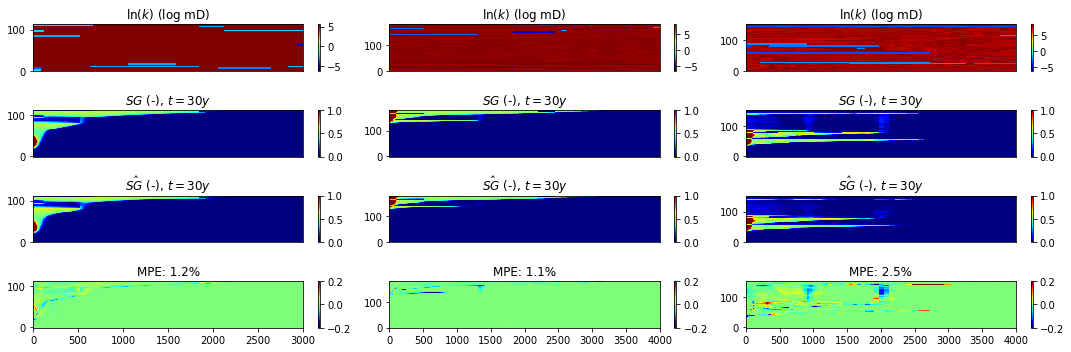

In [20]:
from FNORUNet_5layer_model import *
model1 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/SG3d_FNORUNet_199ep_32width_12m1_12m2_12m3_3000train_200eps_l2err_0.0005lr_1zerr_zscorenorm_andrew_FNORUNet4_5layer', map_location=torch.device('cuda:0'))

n_list = [0, 0, 0] # irrelevant now
fig = plotSG(n_list)

In [ ]:
from FNORUNet_5layer_model import *
model1 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/SG3d_FNORUNet_199ep_32width_12m1_12m2_12m3_3000train_200eps_l2err_0.0005lr_1zerr_zscorenorm_andrew_FNORUNet4_5layer', map_location=torch.device('cuda:0'))

# n_lst = [255, 223, 387] # the indexes of the cases plotted for the SG figure
n_lst = [35, 102, 3]
# n_lst = [255, 102, 223]
# 35, 102, 238
fig = plotSG(n_lst)
# fig.savefig(f'_paper_SGresults_v5.png', dpi=300)
# fig.savefig(f'_paper_SGresults_v5_2.png', dpi=300)

In [18]:
n_lst = [35, 102, 3]

# load data for reservoir n
eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a_SG[n_lst,...], test_u_SG[n_lst,...]), batch_size=1, shuffle=False)

real = np.zeros([3, 96, 200, 24])
predicted = np.zeros([3, 96, 200, 24])

i = 0
with torch.no_grad():
    for x, y in eval_loader:
        x, y = x.to(device), y.to(device)
        pred = model1(x).view(-1,96,200,24)

        y_plot = y.cpu().detach().numpy()
        x_plot = x.cpu().detach().numpy()
        pred_plot = pred.cpu().detach().numpy()

        # un-normalization so that SG is between 0 and 1
        y_plot = y_plot*SG_std + SG_mean
        pred_plot = pred_plot*SG_std + SG_mean
        
        real[i, :, :, :] = y_plot
        predicted[i, :, :, :] = pred_plot        
        i += 1

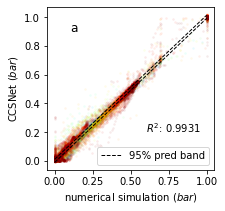

In [22]:
scatter(real[0, :, :, :], predicted[0, :, :, :], name='a')

# PRESSURE BUILDUP

In [8]:
eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a_dP, test_u_dP), batch_size=1, shuffle=False)

from FNORUNet_4layer_model import *
model2 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/dP3d_FNORUNet_249ep_32width_12m1_12m2_12m3_3000train_250eps_l1err_0.0005lr_1zerr_zscorenorm_andrew_FNORUNet4_4layer', map_location=torch.device('cuda:0'))

mre_arr_dptest = []
r2_arr_dptest = []

t1 = default_timer()
with torch.no_grad():
    for x, y in eval_loader:
        x, y = x.to(device), y.to(device)
        pred = model2(x).view(-1,96,200,24)
        
        x_plot = x.cpu().detach().numpy()
        y_plot = y.cpu().detach().numpy() * dP_std + dP_mean
        pred_plot = pred.cpu().detach().numpy() * dP_std + dP_mean
        
        mre_arr_dptest.append(MRE(y_plot, pred_plot))
        r2_arr_dptest.append(R2(y_plot, pred_plot))
t2 = default_timer()
print(round(t2 - t1), "seconds to predict 600 sample test data set for dP model")

print("Mean MRE: ", np.mean(mre_arr_dptest))
print("Std MRE: ", np.std(mre_arr_dptest))
print("Mean R^2: ", np.mean(r2_arr_dptest))
print("Std R^2: ", np.std(r2_arr_dptest))

51 seconds to predict 600 sample test data set for dP model
Mean MRE:  0.0031790351
Std MRE:  0.0023502272
Mean R^2:  0.9967688185929925
Std R^2:  0.004307477635210192


In [9]:
# Get index of the n data samples with smallest MRE values
n=50
metric = mre_arr_dptest
idx = np.argpartition(metric, n)
idx = idx[:n]
sortidx = np.argsort(np.array(metric)[idx])
idx = idx[sortidx]
idx

array([276, 556, 428, 183, 576, 209, 514, 582, 138, 457, 279, 420, 365,
        88, 250, 128, 114, 528, 531, 421, 405, 301,  60, 477, 236, 122,
        23, 529, 320, 462, 483, 252, 463, 493, 526, 168, 234, 325, 581,
       157, 116, 215, 222, 455, 585, 509, 563, 117, 149,  50])

In [26]:
def pcolor(x, X, Y, thickness):
    plt.jet()
    return plt.pcolor(X[:thickness, :200], Y[:thickness, :200], np.flipud(x), shading='auto')
 
def rel_err(yhat, y):
    abs_err = np.abs(y - yhat)
    rel_err = np.zeros(abs_err.shape)
    rel_err = abs_err/(torch.max(y))
    return rel_err

def plotdP(n_lst):
    dx = np.cumsum(3.5938*np.power(1.035012, range(200))) + 0.1
    X, Y = np.meshgrid(dx, np.linspace(0,200,num = 96))
    
    times = np.cumsum(np.power(1.421245, range(24)))
    time_print = []
    for t in range(times.shape[0]):
        if times[t]<365:
            title = str(int(times[t]))+' d'
            time_print = np.append(time_print,title)
        else:
            title = f'{round(int(times[t])/365, 1)} y'
            time_print = np.append(time_print,title)

    # load data for reservoir n
    eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a_dP[n_lst,...], test_u_dP[n_lst,...]), batch_size=1, shuffle=False)
    counter = 0

    fig = plt.figure(figsize=(15,5))

    with torch.no_grad():
        for x, y in eval_loader:
            x, y = x.to(device), y.to(device)
            pred = model2(x).view(-1,96,200,24)

            y_plot = y.cpu().detach().numpy()
            x_plot = x.cpu().detach().numpy()
            pred_plot = pred.cpu().detach().numpy()

            mask = x_plot[0,:,:,0,0] != 0
            fullmask = x_plot[0, :, :, :, 0] != 0
            thickness = sum(mask[:,0])

            # un-normalization
            if normMethod == 'minmax':
                y_plot = y_plot*(dP_max - dP_min) + dP_min
                pred_plot = pred_plot*(dP_max - dP_min) + dP_min
            elif normMethod == 'zscore':
                y_plot = y_plot*dP_std + dP_mean
                pred_plot = pred_plot*dP_std + dP_mean

    #         r2 = rsquared(pred_plot[0,:,:,-1][mask].reshape((thickness, -1)), y_plot[0,:,:,-1][mask].reshape((thickness, -1)))
    #         mpe = MPE(pred_plot[0,:,:,-1][mask].reshape((thickness, -1)), y_plot[0,:,:,-1][mask].reshape((thickness, -1)))
    #         mre = MRE(pred_plot[0,:,:,-1][mask].reshape((thickness, -1)), y_plot[0,:,:,-1][mask].reshape((thickness, -1)))

            r2 = R2(y_plot, pred_plot)
            mre = MRE(y_plot, pred_plot)

#             print('R-squared: ', r2)
#             print('MRE: ', mre)

            if counter == 0:
                xmax = 3000
            else:
                xmax = 4000

            plt.subplot(4,3,counter+1)
            pcolor(np.log(np.exp(x_plot[0,:,:,0,0][mask].reshape((thickness, -1))*15)), X, Y, thickness)
            plt.title('ln($k$) (log mD)')
            plt.colorbar(fraction=0.02)
    #         plt.clim([0, 100])
            plt.xlim([0,xmax])
            plt.xticks([], [])

            plt.subplot(4,3,counter+4)
            #(data_dP_shale - dP_mean)/(dP_std)
            pcolor((y_plot[0,:,:,-1][mask].reshape((thickness, -1)))*dP_std + dP_mean, X, Y, thickness)
            plt.title('$dP$ (bar), $t = 30y$')
            plt.colorbar(fraction=0.02)
    #         plt.clim([0,1])
            plt.xlim([0,xmax])
            plt.xticks([], [])

            plt.subplot(4,3,counter+7)
            pcolor((pred_plot[0,:,:,-1][mask].reshape((thickness, -1)))*dP_std + dP_mean, X, Y, thickness)
            plt.title('$\hat{dP}$ (bar), $t = 30y$')
            plt.colorbar(fraction=0.02)
    #         plt.clim([0,1])
            plt.xlim([0,xmax])
            plt.xticks([], [])

            plt.subplot(4,3,counter+10)
            pred = ((pred_plot[0,:,:,-1][mask].reshape((thickness, -1)))*dP_std + dP_mean)
            true = ((y_plot[0,:,:,-1][mask].reshape((thickness, -1)))*dP_std + dP_mean)
            pcolor((true - pred)/np.max(true), X, Y, thickness)
            plt.colorbar(fraction=0.02)
            plt.title('MRE: ' + f'{np.round(mre, 4) :.4f}' + ', R$^2$: ' + f'{np.round(r2, 4) :.4f}' + ' (-)')
            plt.clim([-0.2,0.2])
            plt.xlim([0,xmax])
    #         if counter==0:
    #             plt.clim([0, 150])
    #         elif counter==1:
    #             plt.clim([0, 800])
    #         elif counter==2:
    #             plt.clim([0, 100])

            counter += 1

    plt.tight_layout()
    plt.show()
    # fig.savefig(f'_paper_dPresults_v4_2.png', dpi=300)
    
    return fig

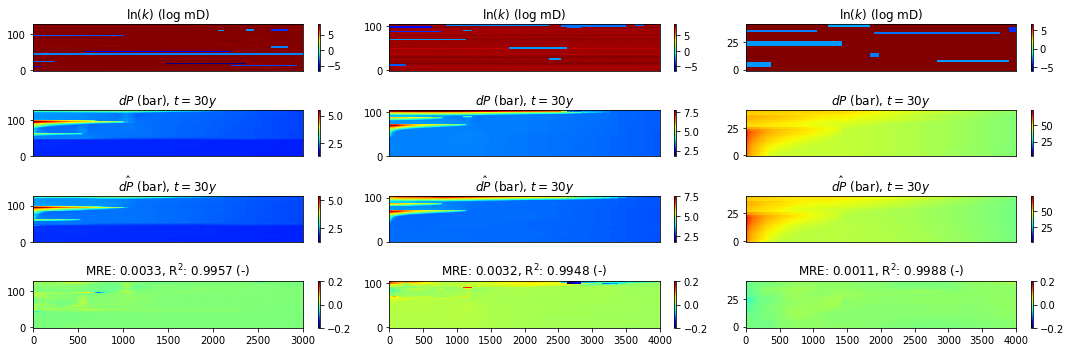

In [28]:
from FNORUNet_4layer_model import *
model2 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/dP3d_FNORUNet_249ep_32width_12m1_12m2_12m3_3000train_250eps_l1err_0.0005lr_1zerr_zscorenorm_andrew_FNORUNet4_4layer', map_location=torch.device('cuda:0'))


# n_lst = [255, 223, 387] # the indexes of the cases plotted for the SG figure
n_lst = [35, 102, 3]
# 35, 102, 238
fig = plotdP(n_lst)
fig.savefig(f'_paper_dPresults_v5.png', dpi=300)